<a href="https://colab.research.google.com/github/akpanitorobong/7135CEM-Modelling_and_Optimization_Under_Uncertainty/blob/main/7135_CEM_Task_1_Gaussian_Process_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Install Libraries**

In [1]:
print("Installing Libraries...")

# Install necessary packages
!pip install ucimlrepo  # For dataset handling
!pip install imbalanced-learn  # For class balancing
!pip install scikit-optimize

# Import Required Libraries
import pandas as pd  # For data manipulation
import numpy as np  # For numerical operations
import matplotlib.pyplot as plt  # For data visualization
import seaborn as sns  # Enhanced visualization
import time  # For tracking execution time

from ucimlrepo import fetch_ucirepo  # For dataset import

from imblearn.under_sampling import RandomUnderSampler# Class balancing

# Feature Scaling & Dimensionality Reduction
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Model Training & Evaluation
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.utils import resample
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

#HyperParameter Tuning
from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV # Import BayesSearchCV from skopt

# Evaluation Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix

print("Libraries imported successfully!")

Installing Libraries...
Libraries imported successfully!


# **Load and Inspect Dataset**

In [2]:
# **Load and Inspect Dataset**
print("Loading dataset...")

# Fetch dataset from UCI Repository
cdc_diabetes_health_indicators = fetch_ucirepo(id=891)

# Extract features and target variables
X = cdc_diabetes_health_indicators.data.features
y = cdc_diabetes_health_indicators.data.targets

# Combine for easy data handling
df = pd.concat([X, y], axis=1)
df.to_csv('diabetes_health_indicators.csv', index=False)

print("Dataset loaded successfully.")
print("\nDataset Info:\n")
df.info()
print("\nFirst 5 Rows:\n")
df.head()
#df = df.sample(1000)

Loading dataset...
Dataset loaded successfully.

Dataset Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype
---  ------                --------------   -----
 0   HighBP                253680 non-null  int64
 1   HighChol              253680 non-null  int64
 2   CholCheck             253680 non-null  int64
 3   BMI                   253680 non-null  int64
 4   Smoker                253680 non-null  int64
 5   Stroke                253680 non-null  int64
 6   HeartDiseaseorAttack  253680 non-null  int64
 7   PhysActivity          253680 non-null  int64
 8   Fruits                253680 non-null  int64
 9   Veggies               253680 non-null  int64
 10  HvyAlcoholConsump     253680 non-null  int64
 11  AnyHealthcare         253680 non-null  int64
 12  NoDocbcCost           253680 non-null  int64
 13  GenHlth               253680 non-null  int64
 14  MentHlth            

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,Diabetes_binary
0,1,1,1,40,1,0,0,0,0,1,...,0,5,18,15,1,0,9,4,3,0
1,0,0,0,25,1,0,0,1,0,0,...,1,3,0,0,0,0,7,6,1,0
2,1,1,1,28,0,0,0,0,1,0,...,1,5,30,30,1,0,9,4,8,0
3,1,0,1,27,0,0,0,1,1,1,...,0,2,0,0,0,0,11,3,6,0
4,1,1,1,24,0,0,0,1,1,1,...,0,2,3,0,0,0,11,5,4,0


# **Preprocessing**

In [3]:
# Remove unnecessary column if present
if "Unnamed: 0" in df.columns:
    df.drop(columns=["Unnamed: 0"], inplace=True)
    print("Column 'Unnamed: 0' removed.")

# Check for and remove duplicate rows
no_of_duplicates = df.duplicated().sum()
df = df.drop_duplicates()
print(f"Number of duplicate rows removed: {no_of_duplicates}")

df = df.dropna()
print("Rows with missing values removed.")

df = df.reset_index(drop=True)
print("Index reset.")

df.head()

Number of duplicate rows removed: 24206
Rows with missing values removed.
Index reset.


,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,Diabetes_binary
0,1,1,1,40,1,0,0,0,0,1,...,0,5,18,15,1,0,9,4,3,0
1,0,0,0,25,1,0,0,1,0,0,...,1,3,0,0,0,0,7,6,1,0
2,1,1,1,28,0,0,0,0,1,0,...,1,5,30,30,1,0,9,4,8,0
3,1,0,1,27,0,0,0,1,1,1,...,0,2,0,0,0,0,11,3,6,0
4,1,1,1,24,0,0,0,1,1,1,...,0,2,3,0,0,0,11,5,4,0


# **Class Balancing**

In [4]:
# Define target variable
target_col = "Diabetes_binary"
X = df.drop(columns=[target_col])  # Features
y = df[target_col]  # Target variable

#Original Data
df_original = pd.DataFrame(X, columns=X.columns)
df_original[target_col] = y  # Add target column back

# Check class distribution before balancing
print("\nClass Distribution Before Balancing:")
print(y.value_counts(), "\n")

# Apply Random Undersampling to balance the dataset
undersampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(X, y)

# Convert back to DataFrame
df_balanced = pd.DataFrame(X_resampled, columns=X.columns)
df_balanced[target_col] = y_resampled  # Add target column back

print("Dataset balanced using Random Undersampling. \nNew class distribution:")
print(df_balanced[target_col].value_counts())


Class Distribution Before Balancing:
Diabetes_binary
0    194377
1     35097
Name: count, dtype: int64 

Dataset balanced using Random Undersampling. 
New class distribution:
Diabetes_binary
0    35097
1    35097
Name: count, dtype: int64


# **Visualization**

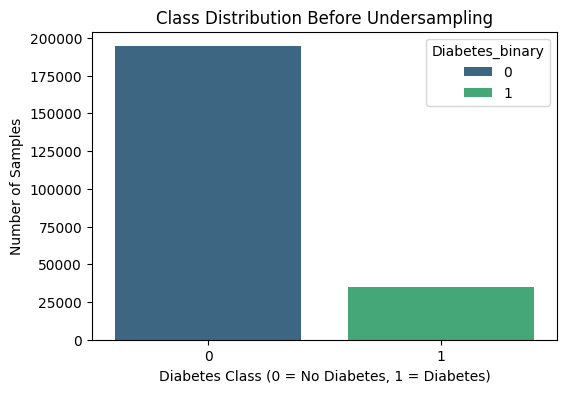

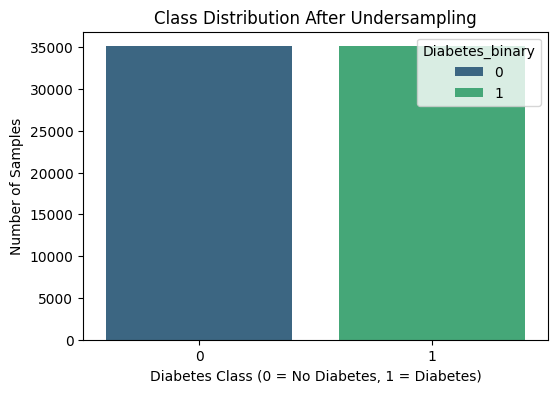

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,Diabetes_binary
199110,0,0,1,19,0,0,0,0,1,1,...,0,3,0,0,0,0,7,4,6,0
220966,0,0,1,24,1,0,1,1,1,1,...,0,2,0,0,0,1,10,5,7,0
9356,0,0,1,23,0,0,0,1,1,1,...,0,3,0,30,0,0,11,6,8,0
31872,0,0,1,34,1,0,0,1,0,1,...,0,2,0,0,0,1,8,4,6,0
66881,0,0,0,24,0,0,0,0,0,1,...,0,3,0,0,0,0,7,6,5,0


In [5]:
 # Plot class distribution before balancing
plt.figure(figsize=(6, 4))
sns.barplot(x=df_original[target_col].value_counts().index,
            y=df_original[target_col].value_counts().values,
            palette="viridis", hue = df_original[target_col].value_counts().index)
plt.xlabel("Diabetes Class (0 = No Diabetes, 1 = Diabetes)")
plt.ylabel("Number of Samples")
plt.title("Class Distribution Before Undersampling")
plt.show()

# Display the first few rows of the cleaned and processed dataset
df_balanced.head()

 # Plot class distribution after balancing
plt.figure(figsize=(6, 4))
sns.barplot(x=df_balanced[target_col].value_counts().index,
            y=df_balanced[target_col].value_counts().values,
            palette="viridis", hue = df_balanced[target_col].value_counts().index)
plt.xlabel("Diabetes Class (0 = No Diabetes, 1 = Diabetes)")
plt.ylabel("Number of Samples")
plt.title("Class Distribution After Undersampling")
plt.show()

# Display the first few rows of the cleaned and processed dataset
df_balanced.head()

# **Standardization**

In [6]:
# Identify numerical columns (excluding categorical features)
num_cols = ["BMI", "MentHlth", "PhysHlth", "Age", "Education", "Income"]

# Standardize numerical features
scaler = StandardScaler()
df_balanced[num_cols] = scaler.fit_transform(df_balanced[num_cols])

print("Numerical features standardized.")
print("Rows affected: ", num_cols)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_balanced.drop(columns=[target_col]),
                                                    df_balanced[target_col],
                                                    test_size=0.2,
                                                    random_state=42)

print("\nData split into training and testing sets.")

Numerical features standardized.
Rows affected:  ['BMI', 'MentHlth', 'PhysHlth', 'Age', 'Education', 'Income']

Data split into training and testing sets.


# **Principal Component Analysis**

In [7]:
# Fit PCA without limiting components
pca_full = PCA().fit(X_train)
print("Total components: " + str(pca_full.n_components_))

# Compute cumulative explained variance
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

# Find the number of components that retain at least 95% variance
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1  # +1 since index starts at 0
print(f"Number of components to retain 95% variance: {n_components_95}")

# Apply PCA with optimal number of components
pca = PCA(n_components=n_components_95)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Check total variance retained
total_variance_retained = np.sum(pca.explained_variance_ratio_)
print(f"Total variance retained: {total_variance_retained:.2f}")

Total components: 21
Number of components to retain 95% variance: 15
Total variance retained: 0.96


# **Model Training and Evaluation**


**Model and Dataset Definition**

In [8]:
# Define datasets
datasets = {
    #"Original": (X_train, X_test),
    #"Feature Importance": (X_train_FI, X_test_FI),
    "PCA": (X_train_pca, X_test_pca),
    #"PCA + Feature Importance": (X_train_pca_fi, X_test_pca_fi)
}

# Define models
models = {
    "Gaussian Process Classifier": GaussianProcessClassifier(),
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "Support Vector Machine": SVC(probability=True),
    "Gradient Boosting Classifier": GradientBoostingClassifier()
}

# Store results
results = []

# Define sampling percentage for Gaussian Process Classifier due to computational needs
gpc_sample_pct = 0.15
print("\nModels defined")


Models defined


**Models Execution**

In [9]:
# Iterate through datasets and models
for dataset_name, (X_tr, X_te) in datasets.items():
    for model_name, model in models.items():
        start_time = time.time()

        # If Gaussian Process Classifier, sample 10% of the data while keeping class balance
        if model_name == "Gaussian Process Classifier":
            X_tr_sampled, y_tr_sampled = resample(
                X_tr, y_train,
                replace=False,
                stratify=y_train,
                n_samples=int(len(X_tr) * gpc_sample_pct),
                random_state=42
            )
        else:
            X_tr_sampled, y_tr_sampled = X_tr, y_train

        # Train model
        print(f"Training {model_name}...")
        model.fit(X_tr_sampled, y_tr_sampled)
        y_pred = model.predict(X_te)
        y_prob = model.predict_proba(X_te)[:, 1] if hasattr(model, "predict_proba") else None

        # Evaluate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_prob) if y_prob is not None else None
        execution_time = time.time() - start_time

        # Store result
        results.append({
            "Model": f"{model_name}",
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1 Score": f1,
            "AUC-ROC": auc,
            "Time (s)": execution_time
        })

Training Gaussian Process Classifier...
Training Logistic Regression...
Training Random Forest...
Training Support Vector Machine...
Training Gradient Boosting Classifier...


# **Results**

In [10]:
# Convert to DataFrame
results_df = pd.DataFrame(results)

# Save to CSV
results_df.to_csv("model_evaluation_results.csv", index=False)

print("Model evaluation complete. Results saved to 'model_evaluation_results.csv'.")

Model evaluation complete. Results saved to 'model_evaluation_results.csv'.
